# MNIST notebook

## import libraries

In [21]:
import os
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # This silences INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
tf.get_logger().setLevel('ERROR')

try:
  import pennylane as qml
except:
  !pip install pennylane
  import pennylane as qml
from pennylane.operation import Operation
import random as rd

## Import the dataset

In [22]:
# !pip install medmnist

In [23]:
# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly
import tensorflow as tf
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter for only the classes 3 and 6
train_filter = np.where((y_train == 6) | (y_train == 3))
test_filter = np.where((y_test == 6) | (y_test == 3))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Use the first 500 images as the training set
x_train, y_train = x_train[:500], y_train[:500]
# Randomly sample 300 images from the remaining data as the validation set
x_val, y_val = x_test[500:800], y_test[500:800]

x_test, y_test = x_test[:300], y_test[:300]

# Rescale the images
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

train_images = np.expand_dims(x_train, -1)
test_images = np.expand_dims(x_test, -1)

def preprocess_images(images):
    # Center-crop to 24x24
    images_cropped = tf.image.central_crop(images, central_fraction=24/28)
    
    # Down-sample to 4x4
    images_downsampled = tf.image.resize(images_cropped, size=(4, 4), method=tf.image.ResizeMethod.BILINEAR)
    
    return images_downsampled

# Preprocess the train, validation, and test images
train_images = preprocess_images(train_images)
test_images= preprocess_images(test_images)

# Map the labels 3 -> 0 and 6 -> 1
y_train_binary = np.where(y_train == 3, 0, 1)
y_test_binary = np.where(y_test == 3, 0, 1)

# Convert the labels to one-hot encoded vectors
train_labels = to_categorical(y_train_binary, 2)
test_labels = to_categorical(y_test_binary, 2)

print("Shape of train labels:", train_labels.shape)
print("Shape of test labels:", test_labels.shape)

Shape of train labels: (500, 2)
Shape of test labels: (300, 2)


In [24]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    grid_size = 5
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

In [25]:
def plot_learning_curve(history):
    # Extracting training and validation accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Extracting training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the accuracy
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


## Common Quantum functions

In [26]:
class RBSGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    def __init__(self, theta, wires):
        super().__init__(theta, wires=wires)
        self.theta = theta

    @staticmethod
    def compute_matrix(theta):
        cos = tf.cos(theta)
        sin = tf.sin(theta)
        return tf.convert_to_tensor([
            [1, 0, 0, 0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ], dtype=tf.float64)

    def adjoint(self):
        return RBSGate(-self.parameters[0], wires=self.wires)

    def label(self, decimals=None, base_label=None, **kwargs):
        theta = self.parameters[0]
        return f"RBS({theta:.2f})"
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = tf.linalg.l2_normalize(X, axis=-1)
    for i in range(X.shape[-1]-1):
        prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
        updated_value = tf.acos(X_normd[..., i] / prod_sin_alphas)
        indices = tf.constant([[i]])
        updates = tf.reshape(updated_value, [1])
        alphas = tf.tensor_scatter_nd_update(alphas, indices, updates)
    return alphas
def vector_loader(alphas, wires=None, is_x=True, is_conjugate=False):
    if wires is None:
        wires = list(range(len(alphas) + 1))
    if is_x and not is_conjugate:
        qml.PauliX(wires=wires[0])
    if is_conjugate:
        for i in range(len(wires) - 2, -1, -1):
            qml.apply(RBSGate(-alphas[i], wires=[wires[i], wires[i+1]]))
    else:
        for i in range(len(wires) - 1):
            qml.apply(RBSGate(alphas[i], wires=[wires[i], wires[i+1]]))
    if is_x and is_conjugate:
        qml.PauliX(wires=wires[0])
def pyramid_circuit(parameters, wires=None):
    if wires is None:
        length = len(qml.device.wires)
    else:
        length = len(wires)

    k = 0

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1

# qOrthNN + Gradient Pruning

In [27]:
import math

# Define a step counter
global_step = tf.Variable(0, dtype=tf.int64, trainable=False)

# Define a custom callback
class StepCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        global_step.assign(0)
    def on_train_batch_end(self, batch, logs=None):
        global_step.assign_add(1)
        current_step = global_step.numpy()
        if current_step % 5 == 0:
            # Increase the pruning ratio
            current_prune_ratio = self.model.prune_ratio
            # Increase prune_ratio by multiplying with exp(0.1)
            new_prune_ratio = min(current_prune_ratio * math.exp(0.1), 1.0)  # Cap at 1.0
            self.model.prune_ratio = new_prune_ratio
    # def on_epoch_begin(self, epoch, logs=None):
    #     tf.print("Updated prune_ratio to", self.model.prune_ratio)

In [28]:
class HybridModel(tf.keras.Model):
    def __init__(self,random1):
        super(HybridModel, self).__init__()
        
        rd.seed(random1)
        np.random.seed(random1)
        tf.random.set_seed(random1)
        qml.numpy.random.seed(random1)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        self.quantum_weights = self.add_weight(
            shape=(15,),
            initializer="zeros",
            trainable=True,
            dtype=tf.float32
        )
        self.dev = qml.device('default.qubit.tf', wires=6)
        # Pruning attributes
        self.accumulated_grads = tf.Variable(tf.zeros_like(self.quantum_weights), trainable=False)
        self.accumulate_flag = tf.Variable(True, trainable=False)
        
        self.accumulate_window = tf.constant(10)
        self.prune_window = tf.constant(6)
        self.prune_ratio = tf.constant(0.)
        
        self.accumulate_count = tf.Variable(6, dtype=tf.int32, trainable=False)
        self.prune_count = tf.Variable(6, dtype=tf.int32, trainable=False)


        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_2 = tf.keras.layers.Dense(2, activation='sigmoid', dtype=tf.float64)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        nn_output = self.classical_nn_2(quantum_outputs)

        return nn_output
    
    @tf.function
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Index of quantum_weights in trainable_variables
        quantum_weights_idx = 0
        
        # switch flag for PGP
        @tf.function
        def switch_flag():
            if self.accumulate_count == 0:
                self.accumulate_count.assign(self.accumulate_window)
                self.accumulate_flag.assign(False)
            elif self.prune_count == 0:
                self.prune_count.assign(self.prune_window)
                self.accumulate_flag.assign(True)
        switch_flag()
        
        # Probabilistic Gradient Pruning
        if tf.equal(self.accumulate_flag, True):
            # Step 1: Accumulate gradients for quantum_weights
            # tf.print("Accu phase:", self.accumulate_count)
            self.accumulate_count.assign_sub(1)
            if gradients[quantum_weights_idx] is not None:
                self.accumulated_grads.assign_add(gradients[quantum_weights_idx])

            # Apply gradients for other variables (excluding quantum_weights)
            # other_gradients = []
            # other_variables = []
            # for i, (grad, var) in enumerate(zip(gradients, self.trainable_variables)):
            #     if i != quantum_weights_idx and grad is not None:
            #         other_gradients.append(grad)
            #         other_variables.append(var)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        else:
            # Step 2: Prune weights of quantum_weights
            # tf.print("Pruning phase:",self.prune_count)
            self.prune_count.assign_sub(1)
            # Normalize the accumulated gradients
            grad_min = tf.reduce_min(self.accumulated_grads)
            grad_max = tf.reduce_max(self.accumulated_grads)
            epsilon = 1e-8
            norm_grads = (self.accumulated_grads - grad_min) / (grad_max - grad_min + epsilon)

            # Add epsilon to norm_grads to avoid log(0)
            norm_grads_with_epsilon = norm_grads + epsilon

            # Compute logits for categorical sampling
            logits = tf.math.log(norm_grads_with_epsilon)

            # Determine the number of parameters to sample
            num_params = self.quantum_weights.shape[0]
            num_samples = int(self.prune_ratio * num_params)
            num_samples = tf.maximum(1, num_samples) # Ensure at least one parameter is sampled

            # Sample indices based on the normalized gradients
            indices = tf.random.categorical([logits], num_samples=num_samples)
            indices = tf.clip_by_value(indices, 0, self.quantum_weights.shape[0] - 1)  # Ensure indices are within range

            # Create a boolean mask to select the parameters to keep
            mask = tf.zeros_like(self.quantum_weights, dtype=tf.bool)
            indices = tf.cast(indices, tf.int32)
            indices = tf.reshape(indices, [-1, 1])  # Ensure indices are shaped correctly
            updates = tf.ones([tf.shape(indices)[0]], dtype=tf.bool)  # Create updates matching the indices length

            mask = tf.tensor_scatter_nd_update(mask, indices, updates)

            # Apply the mask to the accumulated gradients
            pruned_grad = tf.where(mask, self.accumulated_grads[0], tf.zeros_like(self.accumulated_grads[0]))

            # Apply the pruned gradient to quantum_weights
            self.optimizer.apply_gradients([(pruned_grad, self.quantum_weights)])

            # Apply gradients for other variables (excluding quantum_weights)
            other_gradients = []
            other_variables = []
            for i, (grad, var) in enumerate(zip(gradients, self.trainable_variables)):
                if i != quantum_weights_idx and grad is not None:
                    other_gradients.append(grad)
                    other_variables.append(var)
            self.optimizer.apply_gradients(zip(other_gradients, other_variables))

            # Reset accumulator and accumulate window
            self.accumulated_grads.assign(tf.zeros_like(self.accumulated_grads))

        # Sanitize weights: replace NaNs with zeros
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)

        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        # tf.print(self.quantum_weights)
        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}

# Plot the training and validation loss

Training with random seed: 10


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.7018 - loss: 0.5035 - val_accuracy: 0.9233 - val_loss: 0.2476
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9569 - loss: 0.4993 - val_accuracy: 0.9033 - val_loss: 0.2487
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9108 - loss: 0.4985 - val_accuracy: 0.9200 - val_loss: 0.2367
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9677 - loss: 0.5001 - val_accuracy: 0.9367 - val_loss: 0.1984
Testing Process
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9015 - loss: 0.2691
Test Loss: 0.24755577743053436
Test Accuracy: 0.9233333468437195


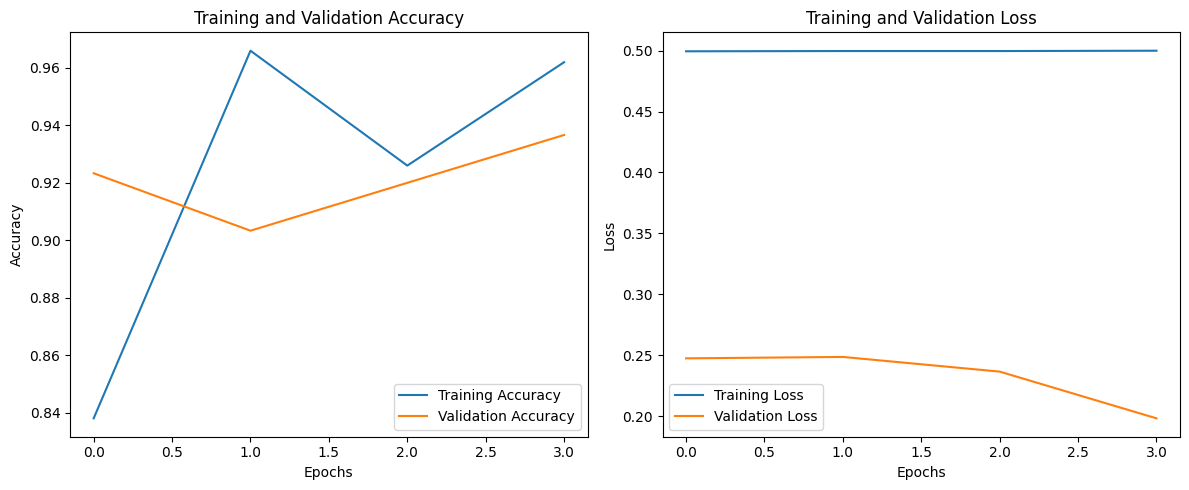

Training with random seed: 20
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.7057 - loss: 0.5127 - val_accuracy: 0.8467 - val_loss: 0.3959
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9319 - loss: 0.5045 - val_accuracy: 0.8567 - val_loss: 0.3670
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9446 - loss: 0.4984 - val_accuracy: 0.9333 - val_loss: 0.2276
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9876 - loss: 0.4986 - val_accuracy: 0.9033 - val_loss: 0.2840
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9706 - loss: 0.5005 - val_accuracy: 0.9167 - val_loss: 0.2677
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9937 - loss: 0.5017 - val_accuracy: 0.8967 - val_loss: 0.3435
Testing Process
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9167 - loss: 0.2659
Test Loss: 0.22763529419898987
Test Accuracy: 0.9333333373069763


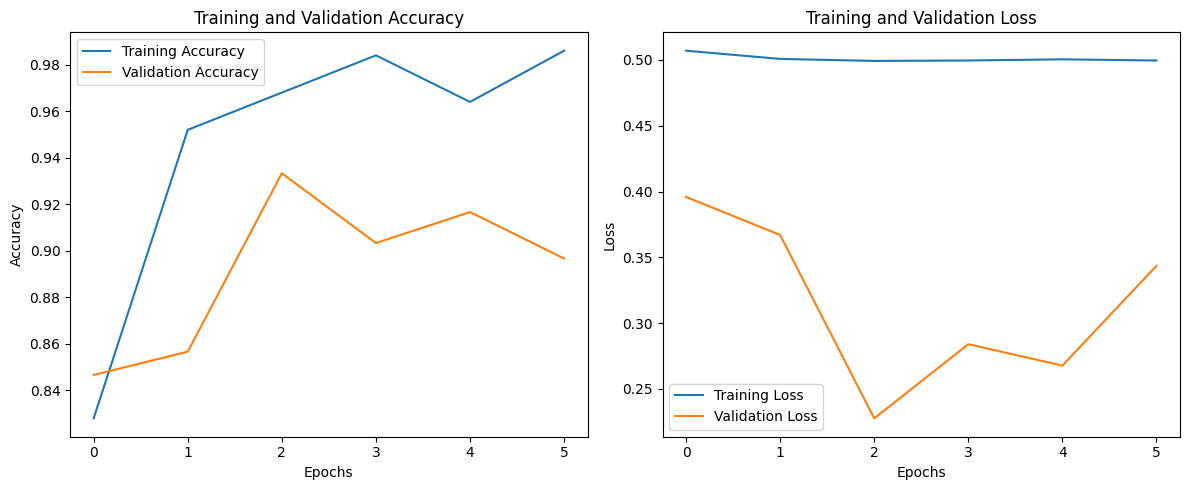

Training with random seed: 30
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.7883 - loss: 0.4909 - val_accuracy: 0.4600 - val_loss: 0.9161
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5771 - loss: 0.5140 - val_accuracy: 0.5400 - val_loss: 0.6905
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4638 - loss: 0.4940 - val_accuracy: 0.4600 - val_loss: 0.8999
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5653 - loss: 0.4857 - val_accuracy: 0.4600 - val_loss: 0.6965
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5639 - loss: 0.4977 - val_accuracy: 0.5400 - val_loss: 0.6910
Testing Process
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5313 - loss: 0.6920
Test Loss: 0.6904610991477966
Test Accuracy: 0.5400000214576721


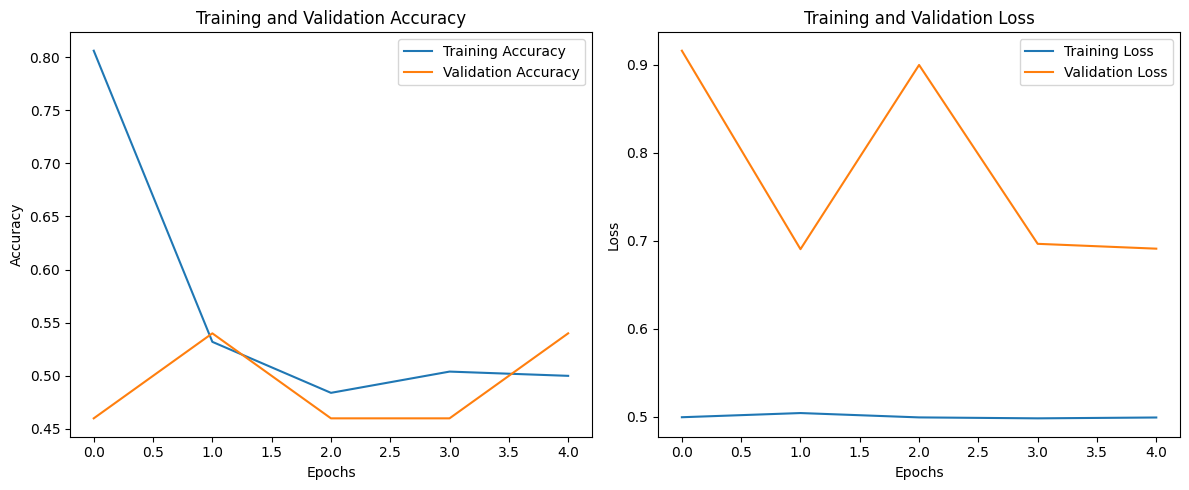

Training with random seed: 40
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.6832 - loss: 0.4961 - val_accuracy: 0.9367 - val_loss: 0.2234
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9582 - loss: 0.5006 - val_accuracy: 0.9367 - val_loss: 0.2068
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9804 - loss: 0.5000 - val_accuracy: 0.9433 - val_loss: 0.1942
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9857 - loss: 0.5004 - val_accuracy: 0.9467 - val_loss: 0.1784
Testing Process
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9184 - loss: 0.2658
Test Loss: 0.22339147329330444
Test Accuracy: 0.9366666674613953


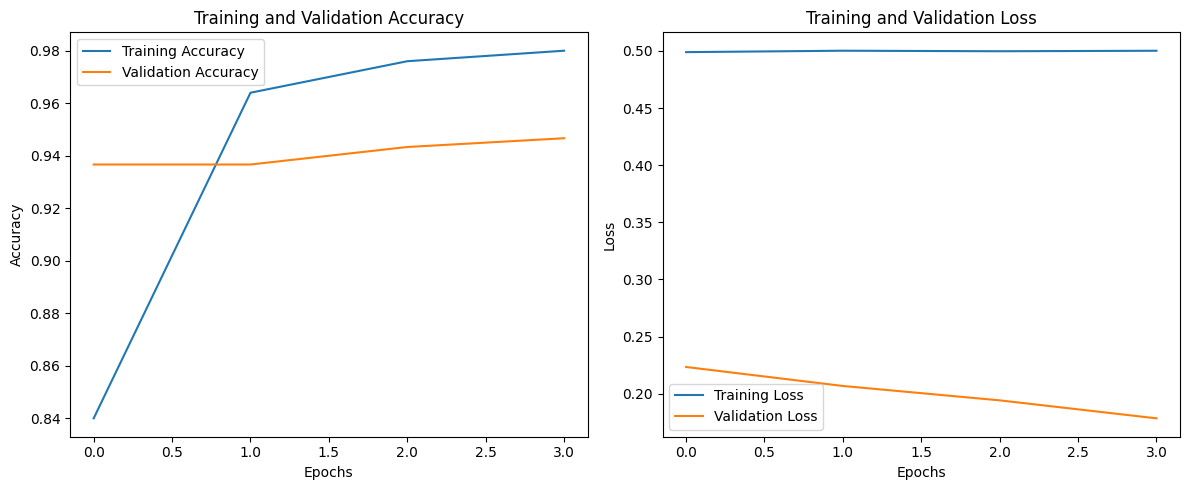

Training with random seed: 50
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.5246 - loss: 0.4921 - val_accuracy: 0.9067 - val_loss: 0.4000
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9560 - loss: 0.4984 - val_accuracy: 0.9333 - val_loss: 0.2024
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9460 - loss: 0.4968 - val_accuracy: 0.9333 - val_loss: 0.2231
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9795 - loss: 0.5002 - val_accuracy: 0.9433 - val_loss: 0.2134
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9689 - loss: 0.4971 - val_accuracy: 0.9400 - val_loss: 0.2351
Testing Process
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9098 - loss: 0.2574
Test Loss: 0.2023574262857437
Test Accuracy: 0.9333333373069763


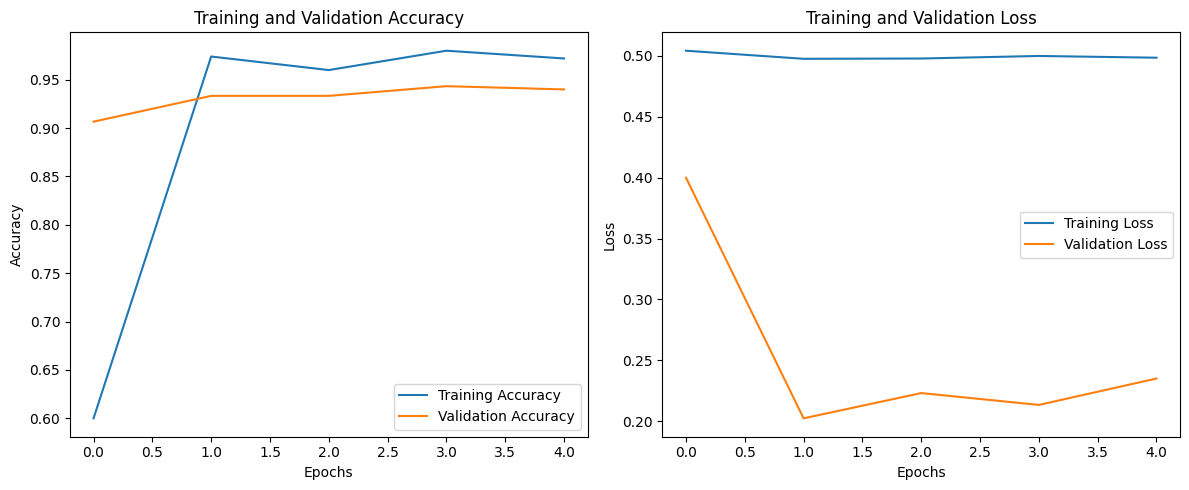

Training with random seed: 60
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7757 - loss: 0.4903 - val_accuracy: 0.8933 - val_loss: 0.2593
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9862 - loss: 0.4965 - val_accuracy: 0.9367 - val_loss: 0.2034
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9889 - loss: 0.4993 - val_accuracy: 0.9100 - val_loss: 0.2505
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9901 - loss: 0.4993 - val_accuracy: 0.9333 - val_loss: 0.2454
Testing Process
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8770 - loss: 0.2826
Test Loss: 0.2592666745185852
Test Accuracy: 0.8933333158493042


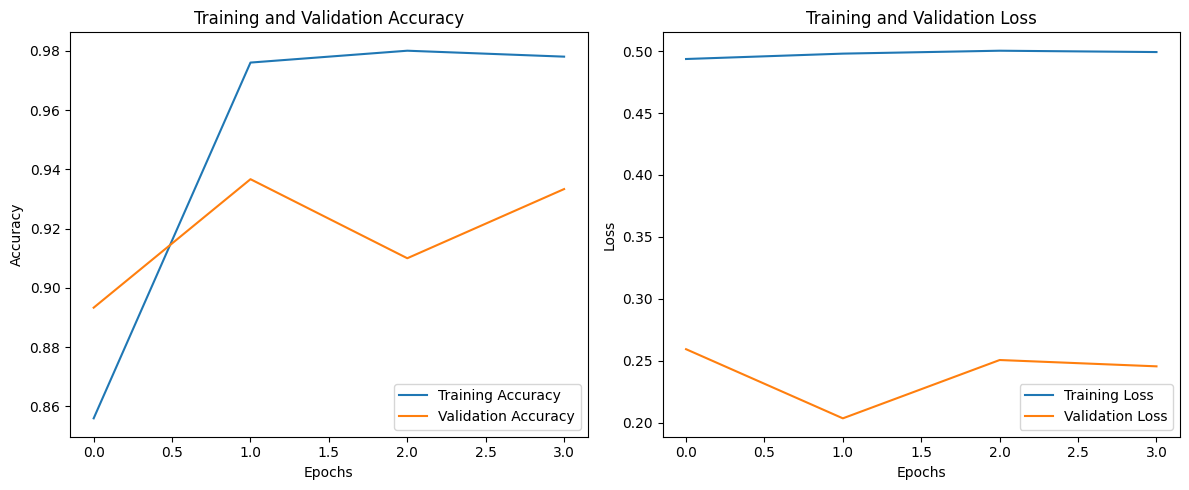

Training with random seed: 70
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7358 - loss: 0.4904 - val_accuracy: 0.9033 - val_loss: 0.2809
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9559 - loss: 0.4998 - val_accuracy: 0.9267 - val_loss: 0.2184
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9752 - loss: 0.5001 - val_accuracy: 0.9133 - val_loss: 0.2579
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9850 - loss: 0.5003 - val_accuracy: 0.9267 - val_loss: 0.2135
Testing Process
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8827 - loss: 0.3465
Test Loss: 0.2809164822101593
Test Accuracy: 0.903333306312561


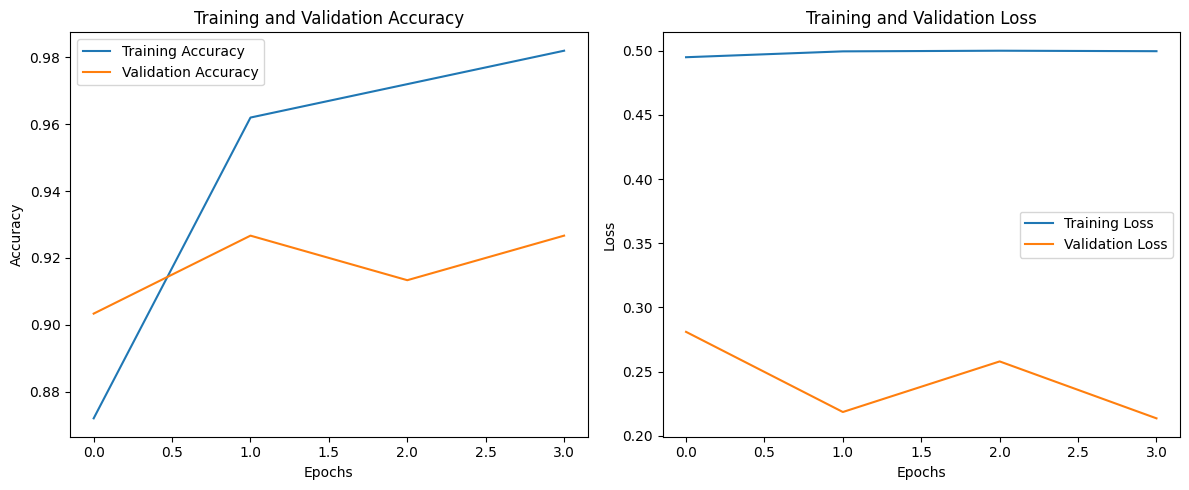

Training with random seed: 80
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.7554 - loss: 0.4880 - val_accuracy: 0.8967 - val_loss: 0.2714
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9361 - loss: 0.4999 - val_accuracy: 0.8767 - val_loss: 0.3534
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9250 - loss: 0.5005 - val_accuracy: 0.8867 - val_loss: 0.3499
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9528 - loss: 0.4999 - val_accuracy: 0.9367 - val_loss: 0.2820
Testing Process
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8778 - loss: 0.3117
Test Loss: 0.2714438736438751
Test Accuracy: 0.8966666460037231


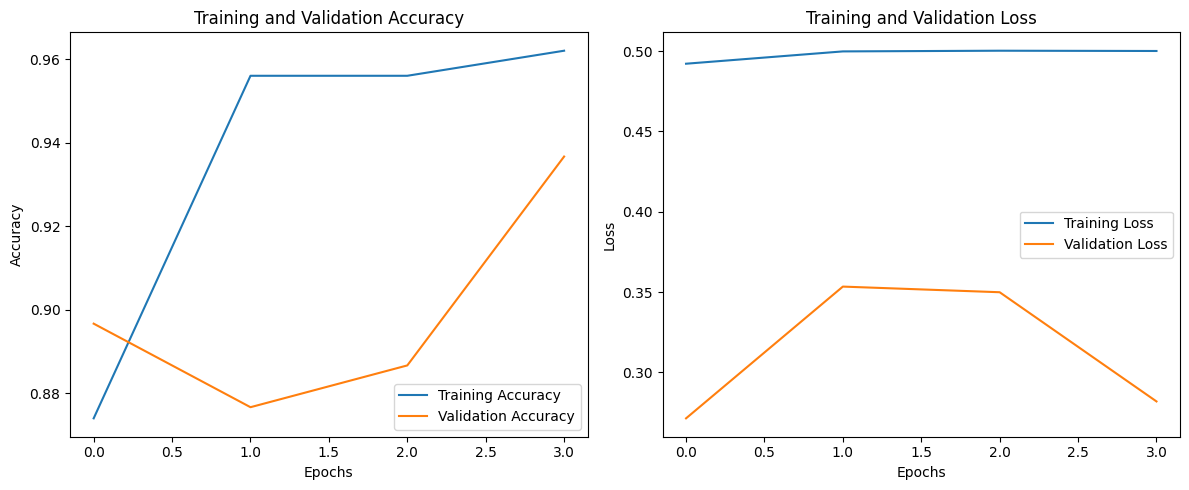

Training with random seed: 90
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.7276 - loss: 0.5135 - val_accuracy: 0.8867 - val_loss: 0.2839
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9548 - loss: 0.5002 - val_accuracy: 0.8333 - val_loss: 0.3778
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9493 - loss: 0.5002 - val_accuracy: 0.9433 - val_loss: 0.1997
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9884 - loss: 0.5000 - val_accuracy: 0.9500 - val_loss: 0.1762
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9806 - loss: 0.5003 - val_accuracy: 0.9500 - val_loss: 0.1882
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9870 - loss: 0.5001 - val_accuracy: 0.9267 - val_loss: 0.2279
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9798 - loss: 0.5021 - val_accuracy: 0.9533 - val_loss: 0.1769
Testing Process
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9466 - los

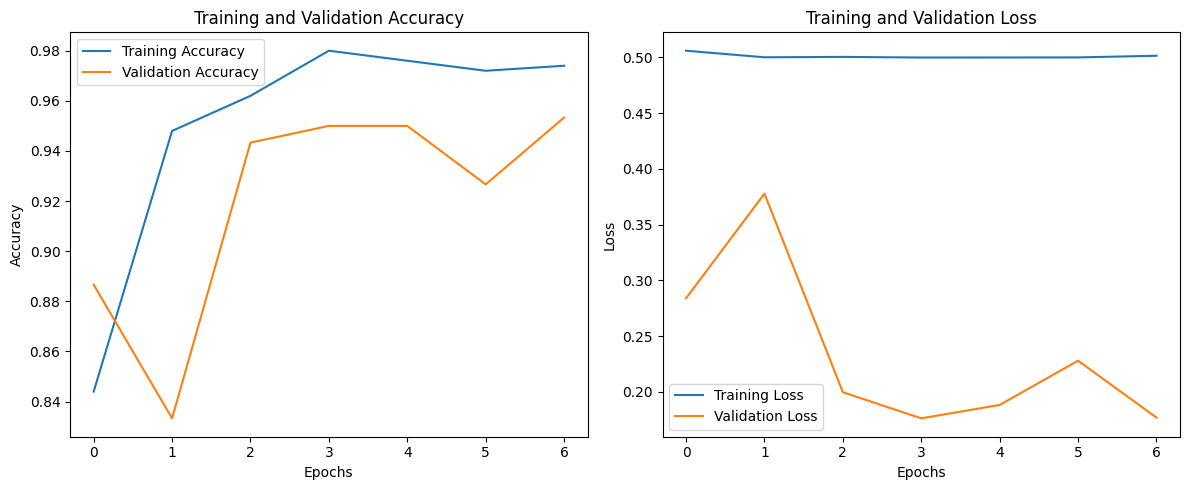

In [29]:
accuracy = []
for random in range(10,100,10):
    rd.seed(random)
    np.random.seed(random)
    tf.random.set_seed(random)
    qml.numpy.random.seed(random)
    print('Training with random seed:', random)
    model = HybridModel(random)
    total_steps = 16  # Example value; adjust based on your training setup
    
    # Cosine learning rate scheduler from 0.3 to 0.03
    initial_learning_rate = 0.3
    final_learning_rate = 0.03
    alpha = final_learning_rate / initial_learning_rate
    
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=total_steps,
        alpha=alpha
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',   # Metric to monitor
        patience=3,           # Number of epochs with no improvement after which training will be stopped
        min_delta=0.1,      # Minimum change to qualify as an improvement
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
    )
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model and store the validation accuracy
    history = model.fit(
        train_images, train_labels,
        epochs=20,
        batch_size=6,
        validation_data=(test_images, test_labels),
        verbose=1,
        callbacks=[early_stopping, StepCallback()]  # Include the EarlyStopping callback
    )

    print('Testing Process')
    test_loss, test_accuracy  = model.evaluate(test_images, test_labels)
    accuracy.append(test_accuracy)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    plot_learning_curve(history)


# Benchmark table 


**10 Times**

Mean accuracy for  MNIST: 0.8789 ± 0.1212

In [30]:
mean_acc_retina_mnist = np.mean(accuracy)
std_acc_retina_mnist = np.std(accuracy)


print(f"Mean accuracy for  MNIST: {mean_acc_retina_mnist:.4f} ± {std_acc_retina_mnist:.4f}")


Mean accuracy for  MNIST: 0.8789 ± 0.1212
